In [51]:
import pickle
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

In [29]:
with open('clean_data.df', 'rb') as pkl:
    df = pickle.load(pkl)
df.reset_index(drop=True, inplace=True)
df

,HR_mean,O2Sat_mean,Temp_mean,SBP_mean,MAP_mean,DBP_mean,Resp_mean,BUN_mean,Calcium_mean,Chloride_mean,...,Phosphate_range,Potassium_range,Hct_range,Hgb_range,WBC_range,Platelets_range,Age,Gender,ICULOS,SepsisLabel
0,73.782609,96.504310,36.454286,105.816176,68.820755,58.110294,22.336207,22.363636,9.241667,106.545455,...,6.0,2.2,2.8,1.1,9.8,36.0,44.90,0.0,117.0,1.0
1,74.564356,97.505376,37.142800,112.931034,75.244828,NaN,19.240000,3.125000,8.225000,104.625000,...,0.8,0.6,7.3,1.5,4.2,62.0,46.43,0.0,107.0,1.0
2,72.300000,98.322222,36.541667,113.777778,69.200000,51.077778,18.476744,32.500000,4.660000,104.333333,...,1.5,1.0,4.6,1.8,5.1,117.0,51.00,1.0,48.0,1.0
3,61.516216,97.221622,36.593913,121.765625,63.800546,43.072917,19.323529,21.727273,8.100000,111.166667,...,1.8,1.2,5.0,1.8,6.6,46.0,81.74,1.0,189.0,1.0
4,121.071429,96.111111,36.436667,117.178571,86.101071,69.410714,22.946429,36.000000,9.000000,101.000000,...,0.0,0.5,1.0,1.2,0.0,0.0,88.65,1.0,29.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18433,74.216216,96.850000,36.046364,98.176471,65.923077,NaN,18.094595,83.000000,8.000000,96.000000,...,0.5,0.6,9.2,0.8,0.8,26.0,79.42,1.0,46.0,0.0
18434,82.360000,95.240000,37.167143,157.364583,87.677083,54.322581,16.340426,12.000000,7.550000,107.000000,...,0.4,0.6,2.0,0.9,1.8,32.0,66.44,1.0,52.0,0.0
18435,71.000000,97.000000,36.833333,123.250000,78.500000,65.250000,20.000000,16.000000,8.600000,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,54.00,0.0,17.0,0.0
18436,68.690476,97.190476,36.683333,138.119048,96.119048,78.309524,15.350000,13.000000,8.300000,NaN,...,NaN,0.9,0.0,0.0,0.0,0.0,57.00,0.0,24.0,0.0


In [30]:
target = 'SepsisLabel'
features = list(df.columns)
features.remove(target)
f'{len(features)} features'

'58 features'

In [31]:
weights = 0.7 * df[target] + 0.3 * (1-df[target])
weights

0        0.7
1        0.7
2        0.7
3        0.7
4        0.7
        ... 
18433    0.3
18434    0.3
18435    0.3
18436    0.3
18437    0.3
Name: SepsisLabel, Length: 18438, dtype: float64

In [32]:
train_data = xgb.DMatrix(df[features], label=df[target], weight=weights)

/Users/snirlugassy/miniconda3/envs/deep/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [33]:
training_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

In [34]:
bst = xgb.train(params=training_params, dtrain=train_data, num_boost_round=10)

In [38]:
y_predict = bst.predict(train_data)
y_predict, type(y_predict)

(array([0.95634896, 0.95451313, 0.0840038 , ..., 0.05072098, 0.04561391,
        0.04629427], dtype=float32),
 numpy.ndarray)

In [43]:
threshold = 0.5
y_predict_label = 1*(y_predict >= threshold)
y_predict_label

array([1, 1, 0, ..., 0, 0, 0])

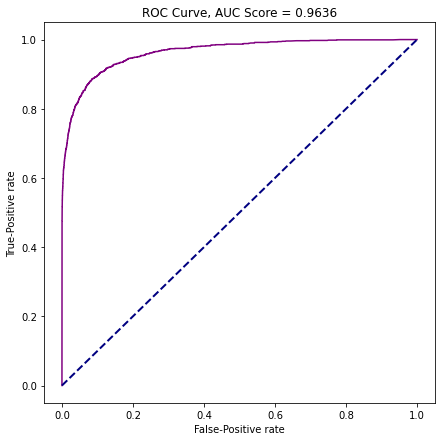

In [61]:
fpr, tpr, thresholds = roc_curve(y_true=df[target], y_score=y_predict)

_auc_score = roc_auc_score(y_true=df[target], y_score=y_predict)

plt.figure(figsize=(7,7))
plt.title(f'ROC Curve, AUC Score = {_auc_score:.4}')
plt.xlabel('False-Positive rate')
plt.ylabel('True-Positive rate')
plt.plot(fpr, tpr, color='purple')
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.show()


In [53]:
f1_score(y_true=df[target], y_pred=y_predict_label)

0.7395121951219512